In [28]:
from typing import Annotated

from IPython.display import Image, display
from langchain_core.messages import AIMessage, AnyMessage, HumanMessage
from langchain_ollama import ChatOllama
from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from pydantic import BaseModel, field_serializer

In [15]:
llm = ChatOllama(model="qwen2.5")

In [16]:
def add(a: int, b: int) -> int:
    """
    Add two integers and return the result.

    Parameters:
        a (int): The first integer.
        b (int): The second integer.

    Returns:
        int: The sum of a and b.
    """
    return a + b

In [17]:
llm = llm.bind_tools([add])
response = llm.invoke([HumanMessage("What is 2 plus 2?", name="Hyan")])

In [18]:
response.tool_calls

[{'name': 'add',
  'args': {'a': 2, 'b': 2},
  'id': '5e2681ee-0ce9-4a11-8ff2-3f746f833e11',
  'type': 'tool_call'}]

In [19]:
class State(BaseModel):
    messages: Annotated[list[AnyMessage], add_messages]

    @field_serializer
    def serialize_messages(self, messages: list[AnyMessage]) -> list[dict]:
        return [message.model_dump() for message in messages]

In [20]:
initial_messages = [
    AIMessage(content="Please tell me how can I help.", name="LlmModel"),
    HumanMessage(content="I want to learn coding.", name="Hyan"),
]

ai_message = AIMessage(
    content="Which programming language do you want to learn?", name="LllModel"
)

In [21]:
add_messages(initial_messages, ai_message)

[AIMessage(content='Please tell me how can I help.', additional_kwargs={}, response_metadata={}, name='LlmModel', id='681ea2b6-85cf-4601-989a-43448078c20a'),
 HumanMessage(content='I want to learn coding.', additional_kwargs={}, response_metadata={}, name='Hyan', id='0bc4d57b-24da-4d35-b1c3-caf8b0cfef41'),
 AIMessage(content='Which programming language do you want to learn?', additional_kwargs={}, response_metadata={}, name='LllModel', id='40d78f45-1b6d-48a3-8fc9-1422f980b4bd')]

In [22]:
class LlmWithTools:
    def __init__(self, llm: ChatOllama) -> None:
        self.llm = llm

    def __call__(self, state: State) -> dict:
        return dict(messages=[self.llm.invoke(state.messages)])

In [23]:
llm = llm.bind_tools([add])

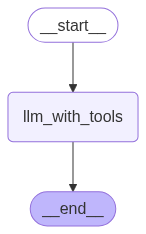

In [24]:
builder = StateGraph(State)
builder.add_node("llm_with_tools", LlmWithTools(llm))
builder.add_edge(START, "llm_with_tools")
builder.add_edge("llm_with_tools", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [26]:
messages = graph.invoke(dict(messages=["What is 2 plus 2?"]))

for message in messages.get("messages"):
    message.pretty_print()

================================ Human Message =================================

What is 2 plus 2?
================================== Ai Message ==================================
Tool Calls:
  add (94d7ffa3-013f-498a-b8bd-9fae57724b06)
 Call ID: 94d7ffa3-013f-498a-b8bd-9fae57724b06
  Args:
    a: 2
    b: 2


In [29]:
tools = [add]

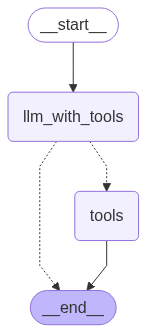

In [33]:
builder = StateGraph(State)
builder.add_node("llm_with_tools", LlmWithTools(llm))
builder.add_node("tools", ToolNode(tools=tools))

builder.add_edge(START, "llm_with_tools")
builder.add_conditional_edges("llm_with_tools", tools_condition)
builder.add_edge("tools", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [35]:
messages = graph.invoke(dict(messages=["What is 2 plus 2?"]))

for message in messages.get("messages"):
    message.pretty_print()

================================ Human Message =================================

What is 2 plus 2?
================================== Ai Message ==================================
Tool Calls:
  add (1dcdc5da-baf7-41c9-b7ce-3328ce3fcc3c)
 Call ID: 1dcdc5da-baf7-41c9-b7ce-3328ce3fcc3c
  Args:
    a: 2
    b: 2
================================= Tool Message =================================
Name: add

4
